In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 -4*x + 5

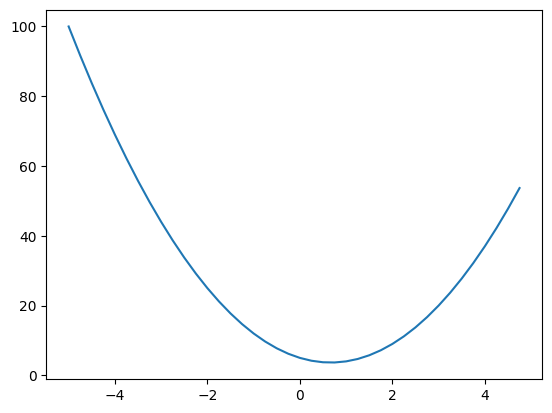

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

## Building data structures to store values and do some basic operations

In [83]:
class Value:
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad 
            other.grad += out.grad          
        out._backward = _backward
        
        return out
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    # Added automatic backpropation functionality and abstracting it
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1
        for node in reversed(topo):
            node._backward()

In [5]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L

Value(data=-8.0)

## Visualizing using graphs

In [6]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [10]:
L.grad = 1

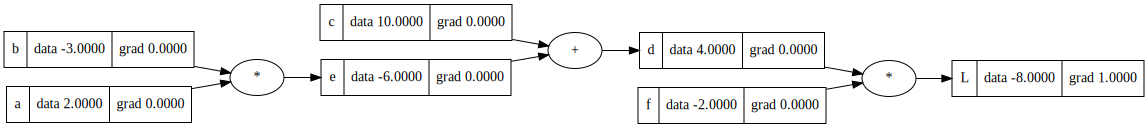

In [11]:
draw_dot(L)

In [15]:
## calculates derivative of a variable (in this case, d) w.r.t L
def lol():
    h = 0.0001
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    d.data += h
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)

lol()

-2.0000000000042206


In [84]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron is b
b = Value(6.8813735870195432, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label="n"
o = n.tanh(); o.label="o"

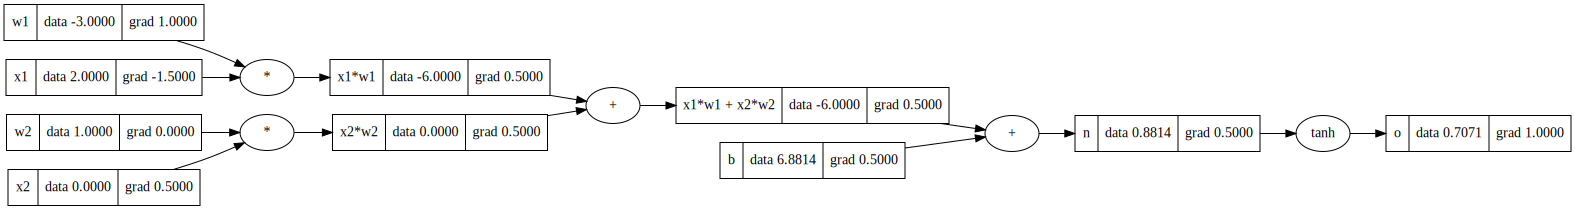

In [87]:
draw_dot(o)

## Automatic backpropagation

### This is my implementation using queue

In [75]:
o.grad = 1.0
queue = []
queue.append(o)
while queue:
    cur = queue.pop(0)
    cur._backward()
    for node in cur._prev:
        queue.append(node)

### Implementation using recursion (topological sort)

In [71]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

In [86]:
o.backward()

## Manual backpropagation

In [27]:
# o = tanh(n) = (e^2*n - 1)/(e^2*n + 1)
# do/dn = ((e^(2*n) + 1) * 2*e^(2*n) - (e^(2*n) - 1) * 2*e^(2*n))/(e^(2*n) + 1)^2
# do/dn = 4*e^(2*n)/(e^(2*n) + 1)^2 = 1 - tanh^2(n) = sech^2(n) = 1/cosh^2(n)

# do/dn = 1-o^2

In [28]:
n.grad = 1 - o.data**2

In [32]:
4*math.exp(2*n.data)/(math.exp(2*n.data) + 1)**2  # just to verify my calculus lol

0.49999999999999994

In [35]:
x1w1x2w2.grad = 0.5  # same as n.grad
b.grad = 0.5  # same as n.grad

In [36]:
x1w1.grad = 0.5  # same as x1w1x2w2.grad
x2w2.grad = 0.5

In [38]:
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

In [88]:
a = Value(3.0, label="a")
b = a + a; b.label="b"
b.backward()

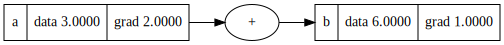

In [89]:
draw_dot(b)